In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from SCFInitialGuess.utilities.usermessages import Messenger as msg

msg.print_level = 0

from os.path import join

plt.style.use(["seaborn", "thesis"])

In [48]:

plt.rcParams['figure.figsize'] = (8, 4)

# Dataset 

In [2]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26
#data_path = "../butadien/data/"
#postfix = ""
#dim = 26

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))


ind = int(0.8 * len(index))


molecules = (molecules[:ind], molecules[ind:])

def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu, ind)

# Model 

In [75]:
filepath = "../../models/" + "TSmall_sto3gmodelTSmall_sto3g_250-150-50+triu.h5"
model = keras.models.load_model(filepath)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 351)               123552    
_________________________________________________________________
dense_1 (Dense)              (None, 601)               211552    
_________________________________________________________________
dense_2 (Dense)              (None, 501)               301602    
_________________________________________________________________
dense_3 (Dense)              (None, 401)               201302    
_________________________________________________________________
dense_4 (Dense)              (None, 351)               141102    
Total params: 979,110
Trainable params: 979,110
Non-trainable params: 0
_________________________________________________________________


# Guesses 

In [4]:
from SCFInitialGuess.utilities.dataset import make_matrix_batch

p_nn = model.predict(s_test)
p_batch = make_matrix_batch(p_nn, dim=dim, is_triu=True).astype("float64")

In [5]:
from SCFInitialGuess.utilities.dataset import make_matrix_batch, extract_triu_batch
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny
from pyscf.scf import hf

#s_raw = make_matrix_batch(dataset.inverse_input_transform(dataset.testing[0]), dim, False)

#p_mcw1 = np.array(list(map(lambda x: multi_mc_wheeny(x[0], x[1], n_max=1), zip(p_batch, s_raw)))).astype("float64")
#p_mcw5 = np.array(list(map(lambda x: multi_mc_wheeny(x[0], x[1], n_max=5), zip  (p_batch, s_raw)))).astype("float64")
p_1e = np.array([
    hf.init_guess_by_1e(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")
p_sap = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")
p_gwh = np.array([
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

# Iterations 

In [6]:
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer


iterations = []

print("nn")
iterations.append(measure_iterations(mf_initializer, p_batch, molecules[1]))
#print("mcw1")
#iterations.append(measure_iterations(mf_initializer, p_mcw1, molecules[1]))
#print("mcw5")
#iterations.append(measure_iterations(mf_initializer, p_mcw5, molecules[1]))
print("h_core")
iterations.append(measure_iterations(mf_initializer, p_1e, molecules[1]))
print("sap")
iterations.append(measure_iterations(mf_initializer, p_sap, molecules[1]))
print("gwh")
iterations.append(measure_iterations(mf_initializer, p_gwh, molecules[1]))

iterations = np.array(iterations).T
iterations.shape

nn
[ ] 2018-12-09 20:43:40: Iteration calculation: 0
[ ] 2018-12-09 20:43:40: Iteration calculation: 1
[ ] 2018-12-09 20:43:40: Iteration calculation: 2
[ ] 2018-12-09 20:43:41: Iteration calculation: 3
[ ] 2018-12-09 20:43:41: Iteration calculation: 4
[ ] 2018-12-09 20:43:41: Iteration calculation: 5
[ ] 2018-12-09 20:43:41: Iteration calculation: 6
[ ] 2018-12-09 20:43:41: Iteration calculation: 7
[ ] 2018-12-09 20:43:41: Iteration calculation: 8
[ ] 2018-12-09 20:43:41: Iteration calculation: 9
[ ] 2018-12-09 20:43:41: Iteration calculation: 10
[ ] 2018-12-09 20:43:41: Iteration calculation: 11
[ ] 2018-12-09 20:43:42: Iteration calculation: 12
[ ] 2018-12-09 20:43:42: Iteration calculation: 13
[ ] 2018-12-09 20:43:42: Iteration calculation: 14
[ ] 2018-12-09 20:43:42: Iteration calculation: 15
[ ] 2018-12-09 20:43:42: Iteration calculation: 16
[ ] 2018-12-09 20:43:42: Iteration calculation: 17
[ ] 2018-12-09 20:43:42: Iteration calculation: 18
[ ] 2018-12-09 20:43:42: Iteration cal

[ ] 2018-12-09 20:43:58: Iteration calculation: 160
[ ] 2018-12-09 20:43:58: Iteration calculation: 161
[ ] 2018-12-09 20:43:58: Iteration calculation: 162
[ ] 2018-12-09 20:43:58: Iteration calculation: 163
[ ] 2018-12-09 20:43:58: Iteration calculation: 164
[ ] 2018-12-09 20:43:58: Iteration calculation: 165
[ ] 2018-12-09 20:43:58: Iteration calculation: 166
[ ] 2018-12-09 20:43:59: Iteration calculation: 167
[ ] 2018-12-09 20:43:59: Iteration calculation: 168
[ ] 2018-12-09 20:43:59: Iteration calculation: 169
[ ] 2018-12-09 20:43:59: Iteration calculation: 170
[ ] 2018-12-09 20:43:59: Iteration calculation: 171
[ ] 2018-12-09 20:43:59: Iteration calculation: 172
[ ] 2018-12-09 20:43:59: Iteration calculation: 173
[ ] 2018-12-09 20:43:59: Iteration calculation: 174
[ ] 2018-12-09 20:43:59: Iteration calculation: 175
[ ] 2018-12-09 20:44:00: Iteration calculation: 176
[ ] 2018-12-09 20:44:00: Iteration calculation: 177
[ ] 2018-12-09 20:44:00: Iteration calculation: 178
[ ] 2018-12-

[ ] 2018-12-09 20:44:27: Iteration calculation: 119
[ ] 2018-12-09 20:44:27: Iteration calculation: 120
[ ] 2018-12-09 20:44:27: Iteration calculation: 121
[ ] 2018-12-09 20:44:27: Iteration calculation: 122
[ ] 2018-12-09 20:44:28: Iteration calculation: 123
[ ] 2018-12-09 20:44:28: Iteration calculation: 124
[ ] 2018-12-09 20:44:28: Iteration calculation: 125
[ ] 2018-12-09 20:44:28: Iteration calculation: 126
[ ] 2018-12-09 20:44:28: Iteration calculation: 127
[ ] 2018-12-09 20:44:28: Iteration calculation: 128
[ ] 2018-12-09 20:44:29: Iteration calculation: 129
[ ] 2018-12-09 20:44:29: Iteration calculation: 130
[ ] 2018-12-09 20:44:29: Iteration calculation: 131
[ ] 2018-12-09 20:44:29: Iteration calculation: 132
[ ] 2018-12-09 20:44:29: Iteration calculation: 133
[ ] 2018-12-09 20:44:29: Iteration calculation: 134
[ ] 2018-12-09 20:44:29: Iteration calculation: 135
[ ] 2018-12-09 20:44:30: Iteration calculation: 136
[ ] 2018-12-09 20:44:30: Iteration calculation: 137
[ ] 2018-12-

[ ] 2018-12-09 20:44:50: Iteration calculation: 78
[ ] 2018-12-09 20:44:50: Iteration calculation: 79
[ ] 2018-12-09 20:44:50: Iteration calculation: 80
[ ] 2018-12-09 20:44:50: Iteration calculation: 81
[ ] 2018-12-09 20:44:50: Iteration calculation: 82
[ ] 2018-12-09 20:44:50: Iteration calculation: 83
[ ] 2018-12-09 20:44:51: Iteration calculation: 84
[ ] 2018-12-09 20:44:51: Iteration calculation: 85
[ ] 2018-12-09 20:44:51: Iteration calculation: 86
[ ] 2018-12-09 20:44:51: Iteration calculation: 87
[ ] 2018-12-09 20:44:51: Iteration calculation: 88
[ ] 2018-12-09 20:44:51: Iteration calculation: 89
[ ] 2018-12-09 20:44:51: Iteration calculation: 90
[ ] 2018-12-09 20:44:52: Iteration calculation: 91
[ ] 2018-12-09 20:44:52: Iteration calculation: 92
[ ] 2018-12-09 20:44:52: Iteration calculation: 93
[ ] 2018-12-09 20:44:52: Iteration calculation: 94
[ ] 2018-12-09 20:44:52: Iteration calculation: 95
[ ] 2018-12-09 20:44:52: Iteration calculation: 96
[ ] 2018-12-09 20:44:52: Iterat

[ ] 2018-12-09 20:45:13: Iteration calculation: 37
[ ] 2018-12-09 20:45:13: Iteration calculation: 38
[ ] 2018-12-09 20:45:13: Iteration calculation: 39
[ ] 2018-12-09 20:45:14: Iteration calculation: 40
[ ] 2018-12-09 20:45:14: Iteration calculation: 41
[ ] 2018-12-09 20:45:14: Iteration calculation: 42
[ ] 2018-12-09 20:45:14: Iteration calculation: 43
[ ] 2018-12-09 20:45:14: Iteration calculation: 44
[ ] 2018-12-09 20:45:14: Iteration calculation: 45
[ ] 2018-12-09 20:45:14: Iteration calculation: 46
[ ] 2018-12-09 20:45:15: Iteration calculation: 47
[ ] 2018-12-09 20:45:15: Iteration calculation: 48
[ ] 2018-12-09 20:45:15: Iteration calculation: 49
[ ] 2018-12-09 20:45:15: Iteration calculation: 50
[ ] 2018-12-09 20:45:15: Iteration calculation: 51
[ ] 2018-12-09 20:45:15: Iteration calculation: 52
[ ] 2018-12-09 20:45:15: Iteration calculation: 53
[ ] 2018-12-09 20:45:16: Iteration calculation: 54
[ ] 2018-12-09 20:45:16: Iteration calculation: 55
[ ] 2018-12-09 20:45:16: Iterat

[ ] 2018-12-09 20:45:36: Iteration calculation: 197
[ ] 2018-12-09 20:45:36: Iteration calculation: 198
[ ] 2018-12-09 20:45:36: Iteration calculation: 199
[ ] 2018-12-09 20:45:36: Iteration calculation: 200


(201, 4)

# Plot 

In [ ]:
labels = ["NN", "H_Core", "SAD", "GWH"]

In [ ]:
from pandas import DataFrame
from seaborn import boxplot

#frame = DataFrame([[iterations[:,i] for i in range(len(labels))]], columns=labels)
frame = DataFrame(iterations, columns=labels)

boxplot(data=iterations)

plt.xticks(np.arange(5), labels)
plt.ylabel("Iterations / 1")
plt.tight_layout()

plt.savefig("/home/jo/Repos/MastersThesis/SMatrixDescriptor/figures/IterationsBoxPlot.pdf")
plt.show()

# Make DataFrame 

In [76]:
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer
from pandas import DataFrame


iterations = []
labels = []
x = []
x_offset = 0.5
x_delta = 2
i = 0

print("nn")
iterations += measure_iterations(mf_initializer, p_batch, molecules[1])
labels += ["NN"] * len(p_batch)
i += 1
x += [x_offset + x_delta * i] * len(p_batch)

print("h_core")
iterations += measure_iterations(mf_initializer, p_1e, molecules[1])
labels += ["H_Core"] * len(p_1e)
i += 1
x += [x_offset + x_delta * i] * len(p_1e)

print("sap")
iterations += measure_iterations(mf_initializer, p_sap, molecules[1])
labels += ["SAD"] * len(p_sap)
i += 1
x += [x_offset + x_delta * i] * len(p_sap)

print("gwh")
iterations += measure_iterations(mf_initializer, p_gwh, molecules[1])
labels += ["GWH"] * len(p_gwh)
i += 1
x += [x_offset + x_delta * i] * len(p_gwh)



enhancement = len(x) * ["Pure"]


nn
h_core
sap
gwh


## Damped 

In [77]:
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer
from pandas import DataFrame


x_offset = 1
x_delta = 2
i = 0

print("nn")
iterations += measure_iterations(mf_initializer, p_batch, molecules[1])
labels += ["NN"] * len(p_batch)
i += 1
x += [x_offset + x_delta * i] * len(p_batch)

print("h_core")
iterations += measure_iterations(mf_initializer, p_1e, molecules[1])
labels += ["H_Core"] * len(p_1e)
i += 1
x += [x_offset + x_delta * i] * len(p_1e)

print("sap")
iterations += measure_iterations(mf_initializer, p_sap, molecules[1])
labels += ["SAD"] * len(p_sap)
i += 1
x += [x_offset + x_delta * i] * len(p_sap)

print("gwh")
iterations += measure_iterations(mf_initializer, p_gwh, molecules[1])
labels += ["GWH"] * len(p_gwh)
i += 1
x += [x_offset + x_delta * i] * len(p_gwh)



enhancement += (len(x) - len(enhancement)) * ["Damped"]


nn
h_core
sap
gwh


## DIIS 

In [78]:
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer
from pandas import DataFrame


x_offset = 1.5
x_delta = 2
i = 0

print("nn")
iterations += measure_iterations(mf_initializer, p_batch, molecules[1])
labels += ["NN"] * len(p_batch)
i += 1
x += [x_offset + x_delta * i] * len(p_batch)

print("h_core")
iterations += measure_iterations(mf_initializer, p_1e, molecules[1])
labels += ["H_Core"] * len(p_1e)
i += 1
x += [x_offset + x_delta * i] * len(p_1e)

print("sap")
iterations += measure_iterations(mf_initializer, p_sap, molecules[1])
labels += ["SAD"] * len(p_sap)
i += 1
x += [x_offset + x_delta * i] * len(p_sap)

print("gwh")
iterations += measure_iterations(mf_initializer, p_gwh, molecules[1])
labels += ["GWH"] * len(p_gwh)
i += 1
x += [x_offset + x_delta * i] * len(p_gwh)



enhancement += (len(x) - len(enhancement)) * ["DIIS"]

nn
h_core
sap
gwh


# Plot 

In [94]:
x_sav = x

In [97]:
x = []
dx = 2

for i in [-0.5, 0, 0.5]:
    for j in range(4):
        x += [j * dx + 1 + i] * 201
        print(x[-1])

0.5
2.5
4.5
6.5
1
3
5
7
1.5
3.5
5.5
7.5


In [99]:
len(x), len(iterations), len(labels), len(enhancement)
#enhancement = ["Pure"]*804 + ["Damping"]*804 + ["DIIS"]*804

(2412, 2412, 4, 2412)

In [100]:
data = DataFrame(
    {
        "x": x,
        "iterations": iterations,
        #"labels": labels,
        "Enhancement": enhancement
    }
)

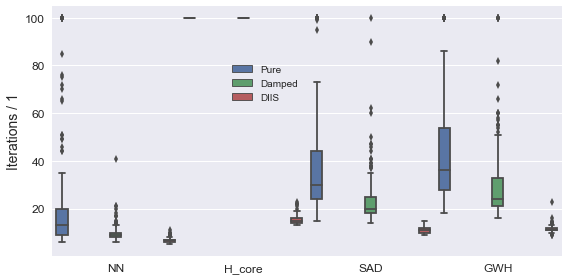

In [105]:
labels = ["NN", "H_core", "SAD", "GWH"]
from pandas import DataFrame
import seaborn as sns

sns.boxplot(data=data, x="x", y="iterations", hue="Enhancement")#, col="enhancement", kind="box", height=4, aspect=.7)

plt.xticks([1, 4, 7, 10], labels)
#plt.xticks(np.arange(10), np.arange(10))
plt.ylabel("Iterations / 1")
plt.xlabel("")
plt.tight_layout()
plt.legend(bbox_to_anchor=(0.5, 0.8))

plt.savefig("/home/jo/Repos/MastersThesis/SMatrixDescriptor/figures/IterationsBoxPlot2.pdf")
plt.show()